# Sensitivity analysis
This study aims to analyse how the parameters we have selected through our model implementation and data processing procedures may affect our results.

In [486]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import io as sio
from pathlib import Path
from scipy.spatial import distance as dist
from sklearn.cluster import DBSCAN
from matplotlib.patches import Ellipse

%matplotlib inline
sns.set_context('notebook')
sns.set_palette(['#0071BC', '#d95319', '#efb320'])

In [457]:
DENSITIES = [2.5, 4.0, 6.0]
VISCOSITIES = [7.96, 18.42, 39.15]

# Force Generator Function
## General shape of the distribution
Firstly, we will look into the effect of the locomotive force generator function. Thus, we will generate multiple force values following a given distribution function, and divide it by the dynamic viscosities of the collagen matrices, resulting in velocity distributions.

In particular, we will study the effect of **two normal distributions**, one of which is centred at 0, and a **lognormal distribution**. These are defined and represented below.

In [458]:
lognormal_dist = {'name': 'Lognormal',
                  'function': np.random.lognormal,
                  'mean': 0.0,
                  'std': 0.7}

normal_dist = {'name': 'Normal',
               'function': np.random.lognormal,
               'mean': 0.15,
               'std': 0.2}

normal_zero_dist = {'name': 'Normal (Zero centred)',
               'function': np.random.lognormal,
               'mean': 0.0,
               'std': 0.45}

distributions = [normal_dist, normal_zero_dist, lognormal_dist]

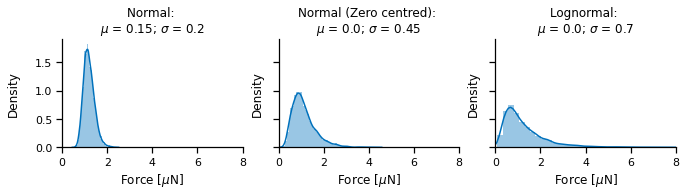

In [461]:
number_of_points = 5000
fig, axes = plt.subplots(1, 3, figsize=(11, 2), sharey=True)

for i, dist in enumerate(distributions):
    output = dist['function'](dist['mean'], dist['std'], number_of_points)

    sns.distplot(output, ax=axes[i])
    sns.despine()
    axes[i].set_title('{}: \n$\mu$ = {}; $\sigma$ = {}'.format(dist['name'], dist['mean'], dist['std']))
    axes[i].set_xlim(0, 8)
    axes[i].set_ylabel('Density', labelpad=15)
    axes[i].set_xlabel('Force [$\mu$N]')

Translating these force values into velocity distributions, we conclude that none of the distributions fits the experimental results. However, the lognormal distribution is the one that best approximates to the empirical distribution.

(0.0, 0.4)

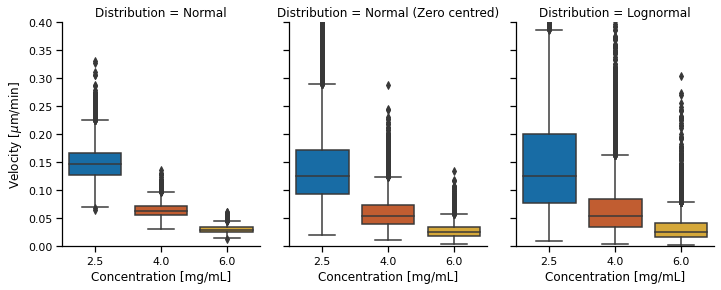

In [459]:
number_of_cells = 150
number_of_timepoints = 73
velocities = []

for dist in distributions:
    for density, viscosity in zip(DENSITIES, VISCOSITIES):
        for cell in range(number_of_cells):
            for time in range(number_of_timepoints):
                force = abs(dist['function'](dist['mean'], dist['std']))
                velocity = force/viscosity
                velocities.append([velocity, density, dist['name']])
            
velocity_df = pd.DataFrame(velocities, columns=['Velocity [$\mu$m/min]', 
                                                'Concentration [mg/mL]', 'Distribution'])


sns.catplot(data=velocity_df, x='Concentration [mg/mL]', y='Velocity [$\mu$m/min]',
            hue='Concentration [mg/mL]', col='Distribution', kind='box',
            dodge=False, legend=False, height=4.2, aspect=0.8)

# Figure aesthetics
plt.ylim(0, 0.4)

Let's define a function that allows us to generate a distribution function similar to that seen in the experiments.

In [445]:
def empirical_dist_custom(input_value, a, b, c, d):
    force_value = a*input_value**3  + b*input_value**2 + c*input_value + d
    
    return force_value

Text(0.5, 1.05, 'Expected Results')

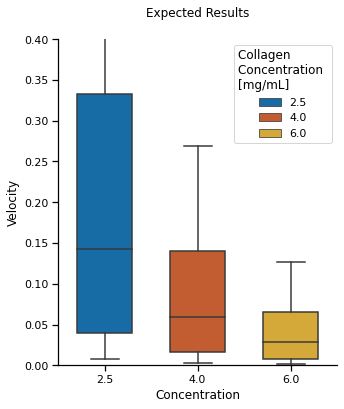

In [465]:
velocities = []

for density, viscosity in zip(DENSITIES, VISCOSITIES):
    for cell in range(number_of_cells):
        for time in range(number_of_timepoints):
            random_value = np.random.uniform()
            force = empirical_dist_custom(random_value, 1.56, 3.27, 0.07, 0.06)
            velocity = force/viscosity
            velocities.append([velocity, density])
            
velocity_df = pd.DataFrame(velocities, columns=['Velocity', 'Concentration'])

plt.figure(figsize=(5,6))
sns.boxplot(data=velocity_df, x='Concentration', y='Velocity',
            hue='Concentration', width=0.6, dodge=False)

# Figure aesthetics
plt.ylim(0, 0.4)
sns.despine()
plt.legend(loc='upper right', title='Collagen \nConcentration \n[mg/mL]')
plt.title('Expected Results', y=1.05)

## Coefficients of the locomotive force generator function
The second question we want to address is the role of the coefficient values of our own generator function (defined above). Hence, we will vary these values according to their magnitude and see how the model responds to small perturbations in these values.

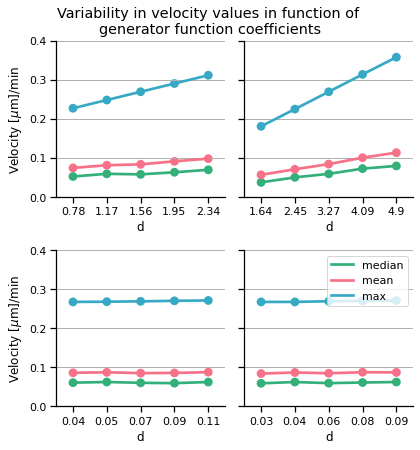

In [475]:
sns.set_palette('husl', 5)
colors = ['C2', 'C0', 'C3']
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True)
axes = axes.ravel()

# Values used in the simulations
coeff_values = {'a': 1.56,
                     'b': 3.27,
                     'c': 0.07,
                     'd': 0.06}

for ax, coeff in zip(axes, ['a', 'b', 'c', 'd']):
    # Set coefficients back to the original values
    a = coeff_values['a']
    b = coeff_values['b']
    c = coeff_values['c']
    d = coeff_values['d']
    
    # Define range of variation
    value_of_coord = coeff_values[coeff]
    bottom_lim = value_of_coord*0.5
    upper_lim = value_of_coord*1.5
    vals = []

    for value in np.round(np.linspace(bottom_lim, upper_lim, 5), 2):
        # Change only the value of one of the coefficients
        if coeff == 'a':
            a = value
        elif coeff == 'b':
            b = value
        elif coeff == 'c':
            c = value
        elif coeff == 'd':
            d = value
        
        # Generate velocity distribution
        for i in range(5000):
            # Generate locomotive force
            random_value = np.random.uniform()
            output = empirical_dist_custom(random_value, a, b, c, d)
            # Compute velocity value
            vals.append([output/VISCOSITIES[1], value])

    dist = pd.DataFrame(vals, columns=['output', coordinate])
    
    # Plot variation of mean, median and max values
    labels = ['median', 'mean', 'max']
    for metric, label, color in zip([np.median, np.mean, np.max], labels, colors):
        sns.pointplot(data=dist, x=coordinate, y='output',
                     estimator=metric,
                     color=color, label=label,
                     ax=ax)
    
    # Figure aesthetics
    ax.grid(axis='y')
    if coeff == 'a' or coeff == 'c':
        ax.set_ylabel('Velocity [$\mu$m]/min', labelpad=5)
    else:
        ax.set_ylabel('')
    
    # Legend
    if coeff == 'd':
        ax.legend(labels=labels, loc='upper right')
        leg = ax.get_legend()
        for color_index, color in enumerate(colors):
            leg.legendHandles[color_index].set_color(color)

    ax.set_ylim(0, 0.4)
    sns.despine()
    
plt.suptitle('Variability in velocity values in function of \ngenerator function coefficients', y=1.04)
plt.tight_layout()

# Data Processing
## Height of interest
### Area

In [487]:
### EXTRACT CELL DATA
number_of_replicates = 10
variables = ['ID', 'position_x', 'position_y', 'position_z']
base_folder_name = Path('../data/Final_550_72')
cell_radius = 8
densities_folders_names = ['Med', 'High']
timepoints_of_interest = [1, 3, 5]
radius = 18

cluster_list = []

for z_height in [50, 150, 250]:
    for density in densities_folders_names:
        density_folder = base_folder_name / '{}Density/'.format(density)
        for timestep in timepoints_of_interest:
            for replicate in range(1, number_of_replicates+1):
                replicate_folder = 'output{}'.format(replicate)
                cells_folder = density_folder / replicate_folder

                # Extract cell data from output files
                cells = get_cell_data(timestep, cells_folder, variables)
                # Transform data into a DataFrame
                cells_df = pd.DataFrame(cells, columns=variables)

                # Select cells in the height of interest
                cells_df = cells_in_z_area_of_interest(cells_df, z_height)

                # Classify cells into clusters
                if timestep == 1:
                    min_cells = 2
                else:
                    min_cells = 3

                cells_df = classify_cells_into_clusters(cells_df, DBSCAN_min_cells=min_cells)

                # Compute the distance of each cell to its cluster center
                cells_df = add_cluster_data(cells_df)

                # Cluster metrics
                clusters_data = cells_df.groupby('cluster')
                cluster_list = compute_cluster_metrics(clusters_data, cluster_list)

In [488]:
cluster_df = pd.DataFrame(cluster_list, columns=['height', 'radius', 'min_cells', 
                                                 'density','replicate', 'timestep', 
                                                 'id', 'x', 'y', 
                                                 'dist', 'rad', 'area', 'num'])

cluster_df['days'] = cluster_df['timestep']
cluster_df['Collagen Concentration'] = np.nan

concentrations = [4.0, 6.0]

for concentration, density in zip(concentrations, densities_folders_names):
    cluster_df.loc[cluster_df['density'] == density, 'Collagen Concentration'] = concentration

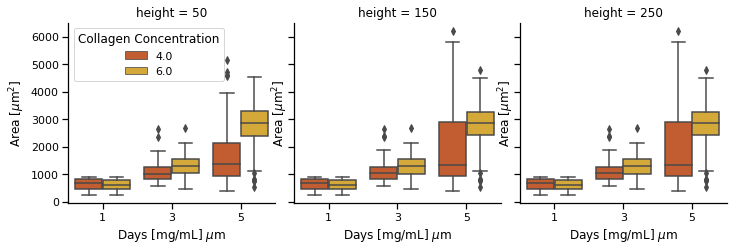

In [489]:
sns.set_palette(['#d95319', '#efb320'])
g = sns.catplot(data=cluster_df, x='timestep', y='area', hue='Collagen Concentration',
            col='height', kind='box', sharey=True, legend_out=False,
            height=3.6, aspect=0.95)

g.set(ylabel='Area [$\mu$m$^2$]', xlabel='Days [mg/mL] $\mu$m')

### Eccentricity

In [509]:
eccentricity_list = []
number_of_replicates = 10
for z_heigth in [40, 120, 360]:
    for density in densities_folders_names:
        density_folder = base_folder_name / '{}Density/'.format(density)
        for replicate in range(1, number_of_replicates+1):
            replicate_folder = 'output{}/'.format(replicate)
            cells_folder = density_folder / replicate_folder

            # Extract cell data from output files
            cells = get_cell_data(timestep, cells_folder, variables)
            # Transform data into a DataFrame
            cells_df = pd.DataFrame(cells, columns=variables)

            cells_df = cells_in_z_area_of_interest(cells_df, z_heigth)

            # Clusterization
            cells_df = classify_cells_into_clusters(cells_df,
                                                    DBSCAN_radius=18,
                                                    DBSCAN_min_cells=3)

            # Distance Calculation
            cells_df = add_cluster_data(cells_df)

            # Cluster metrics
            clusters_data = cells_df.groupby('cluster')
            averaged_cluster_data = clusters_data.mean()

            clusters = averaged_cluster_data.index

            # Compute eccentricity and plot equivalent ellipses of each cluster
            # Only clusters with an area larger than 2000 micron^2 will be considered
            for cluster in np.unique(cells_df['cluster']):
                # Select cells from the cluster
                cluster_cells = cells_df[cells_df['cluster'] == cluster]

                # Get spatial information
                cluster_position_x = cluster_cells['position_x']
                cluster_position_y = cluster_cells['position_y']

                # Compute cluster area
                mean_distance_to_centroid = averaged_cluster_data.loc[cluster]['distance_to_centroid']
                cluster_radius = mean_distance_to_centroid + cell_radius
                cluster_area = cluster_radius**2 * np.pi

                if cluster_area > 2300:
                    # Compute equivalent ellipse (using the second moment method)
                    # Format spatial data
                    coords = [(x,y) for x, y in zip(cluster_position_x, cluster_position_y)]
                    coords = np.array(coords)
                    # Get ellipse metrics
                    center_of_ellipse, ellipse_x, ellipse_y, rotation_angle = compute_equivalent_ellipse(coords)

                    # Compute eccentricity of the ellipse
                    eccentricity = compute_eccentricity(ellipse_x, ellipse_y)

                    eccentricity_list.append([z_heigth, density, eccentricity])

In [510]:
eccentricity_df = pd.DataFrame(eccentricity_list, columns=['Height', 'density', 'eccentricity'])

eccentricity_df['Collagen Concentration [mg/mL]'] = np.nan

concentrations = [4.0, 6.0]

for concentration, density in zip(concentrations, densities_folders_names):
    eccentricity_df.loc[eccentricity_df['density'] == density, 'Collagen Concentration [mg/mL]'] = concentration

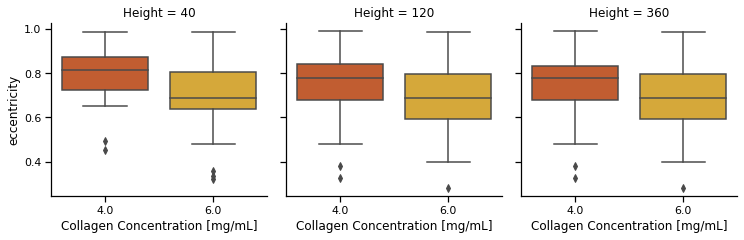

In [511]:
sns.catplot(data=eccentricity_df, x='Collagen Concentration [mg/mL]', y='eccentricity',
            col='Height', kind='box', 
            height=3.5)

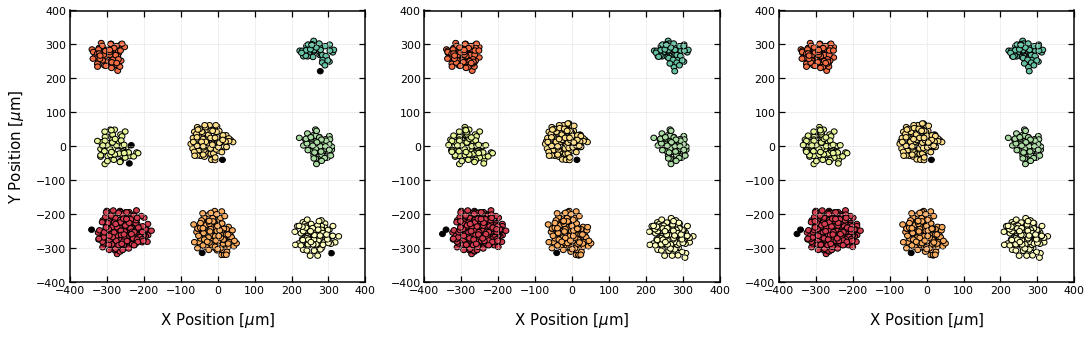

In [496]:
densities_folder = 'High'
concentration = 6.0                   
timestep = 7                                       
replicate = 2

# Create fig object
fig, axes = plt.subplots(1,3)
fig.set_figwidth(18)
fig.set_figheight(5)

for index, z_height in enumerate([40, 120, 360]):
    # Extract cell data from output folders
    density_folder = base_folder_name / '{}Density/'.format(densities_folder)
    replicate_folder = 'output{}/'.format(replicate)
    cells_folder = density_folder / replicate_folder
    
    cells = get_cell_data(timestep, cells_folder, variables)
    
    cells_df = pd.DataFrame(cells, columns=variables)
    cells_df = cells_in_z_area_of_interest(cells_df, z_height)

    # Clusterization
    cells_df = classify_cells_into_clusters(cells_df, DBSCAN_min_cells=3)
    
    # Define ax to draw in
    ax = axes[index]
    
    # Plot cells with an accurate representation of the assumed geometry
    draw_cells_as_circles(ax, cells_df, y_variable='position_y', clusterized=True)
    
    # Figure aesthetics
    ax.set_ylim(-400,400)
    ax.set_xlim(-400,400)
    
    # Use the standard axes style
    set_cell_view_style_axes(ax)
    
    #ax.set_title("Collagen concentration: {} [mg/mL]".format(concentrations[index]), y=1.05, fontsize=15)
    
    ax.set_xlabel("X Position [$\mu$m]", labelpad=15, fontsize=15)
    
    # Only add a y label to the left ax
    if index == 0:
        ax.set_ylabel("Y Position [$\mu$m]", labelpad=10, fontsize=15)

## DBSCAN parameters
### Area

In [512]:
### EXTRACT CELL DATA
number_of_replicates = 10
densities_folders_names = ['Med', 'High']
timestep = 5


cluster_list = []

for radius in [15, 17.5, 20, 22.5]:
    for min_cells in [2, 3, 4, 5]:
        for density in densities_folders_names:
            density_folder = base_folder_name / '{}Density/'.format(density)
            for replicate in range(1, number_of_replicates+1):
                replicate_folder = 'output{}'.format(replicate)
                cells_folder = density_folder / replicate_folder

                # Extract cell data from output files
                cells = get_cell_data(timestep, cells_folder, variables)
                # Transform data into a DataFrame
                cells_df = pd.DataFrame(cells, columns=variables)


                cells_df = classify_cells_into_clusters(cells_df,
                                                        DBSCAN_min_cells=min_cells,
                                                        DBSCAN_radius=radius)

                # Compute the distance of each cell to its cluster center
                cells_df = add_cluster_data(cells_df)

                # Cluster metrics
                clusters_data = cells_df.groupby('cluster')
                cluster_list = compute_cluster_metrics(clusters_data, cluster_list)

In [498]:
cluster_df = pd.DataFrame(cluster_list, columns=['height', 'radius', 'min_cells', 'density','replicate', 'timestep', 
                                                 'id', 'x', 'y', 'dist', 'rad', 'area', 'num'])

cluster_df['days'] = cluster_df['timestep']
cluster_df['Collagen Concentration'] = np.nan

concentrations = [4.0, 6.0]

for concentration, density in zip(concentrations, densities_folders_names):
    cluster_df.loc[cluster_df['density'] == density, 'Collagen Concentration'] = concentration

Text(0.5, 0.85, 'Mean cluster area in function of DBSCAN parameters [$\\mu$m$^2$]')

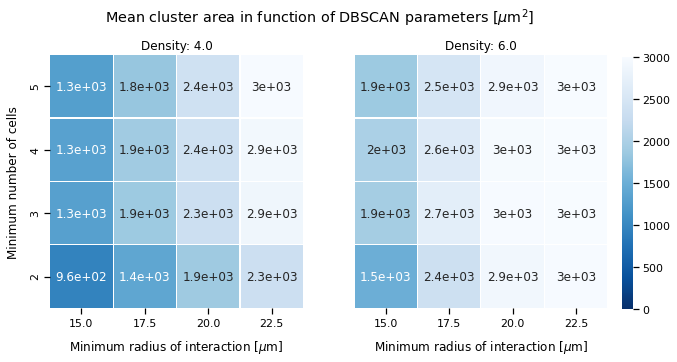

In [499]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
cbar_ax = fig.add_axes([.92, .25, .015, .5])

for index, density in enumerate(['Med', 'High']):
    med_df = cluster_df[cluster_df['density'] == density][['radius', 'min_cells', 'area']]

    med_df = med_df.groupby(['min_cells', 'radius'], sort=False).agg(['mean'])
    med_df.columns = med_df.columns.droplevel(0)
    med_df.reset_index(inplace=True)
    med_df.head()
    result = pd.pivot_table(med_df, values='mean', 
                         index=['min_cells'], 
                         columns='radius')
    
    sns.heatmap(result, vmin=0, vmax=3000,
                annot=True,
                linewidths=0.2, square=True,
                cmap='Blues_r',
                ax=axes[index],
                cbar=index == 0, 
                cbar_ax=None if index else cbar_ax)
    
    axes[index].set_title('Density: {}'.format(concentrations[index]))
    axes[index].set_xlabel('Minimum radius of interaction [$\mu$m]', labelpad=10)
    axes[index].invert_yaxis()
    
    
axes[0].set_ylabel('Minimum number of cells', labelpad=10)
axes[1].set_ylabel('')
axes[1].set_yticks([])
plt.suptitle('Mean cluster area in function of DBSCAN parameters [$\mu$m$^2$]', y=0.85)

### Eccentricity

In [513]:
densities_folders_names = ['Med', 'High']
timestep = 7
number_of_replicates = 10
eccentricity_list = []

for number_of_cells in [2, 3, 4, 5]:
    for DB_radius in [15, 17.5, 20, 22.5]:
        for density in densities_folders_names:
            density_folder = base_folder_name / '{}Density/'.format(density)
            for replicate in range(1, number_of_replicates+1):
                replicate_folder = 'output{}/'.format(replicate)
                cells_folder = density_folder / replicate_folder

                # Extract cell data from output files
                cells = get_cell_data(timestep, cells_folder, variables)
                # Transform data into a DataFrame
                cells_df = pd.DataFrame(cells, columns=variables)

                # Clusterization
                cells_df = classify_cells_into_clusters(cells_df,
                                                        DBSCAN_radius=DB_radius,
                                                        DBSCAN_min_cells=number_of_cells)

                # Distance Calculation
                cells_df = add_cluster_data(cells_df)

                # Cluster metrics
                clusters_data = cells_df.groupby('cluster')
                averaged_cluster_data = clusters_data.mean()

                clusters = averaged_cluster_data.index

                # Compute eccentricity and plot equivalent ellipses of each cluster
                # Only clusters with an area larger than 2000 micron^2 will be considered
                for cluster in np.unique(cells_df['cluster']):
                    # Select cells from the cluster
                    cluster_cells = cells_df[cells_df['cluster'] == cluster]

                    # Get spatial information
                    cluster_position_x = cluster_cells['position_x']
                    cluster_position_y = cluster_cells['position_y']

                    # Compute cluster area
                    mean_distance_to_centroid = averaged_cluster_data.loc[cluster]['distance_to_centroid']
                    cluster_radius = mean_distance_to_centroid + cell_radius
                    cluster_area = cluster_radius**2 * np.pi

                    if cluster_area > 2300:
                        # Compute equivalent ellipse (using the second moment method)
                        # Format spatial data
                        coords = [(x,y) for x, y in zip(cluster_position_x, cluster_position_y)]
                        coords = np.array(coords)
                        # Get ellipse metrics
                        center_of_ellipse, ellipse_x, ellipse_y, rotation_angle = compute_equivalent_ellipse(coords)

                        # Compute eccentricity of the ellipse
                        eccentricity = compute_eccentricity(ellipse_x, ellipse_y)

                        eccentricity_list.append([number_of_cells, DB_radius, density, eccentricity])

In [515]:
eccentricity_df = pd.DataFrame(eccentricity_list, columns=['n_cells', 'radius', 'density', 'eccentricity'])

eccentricity_df['Collagen Concentration'] = np.nan

concentrations = [4.0, 6.0]

for concentration, density in zip(concentrations, densities_folders_names):
    eccentricity_df.loc[eccentricity_df['density'] == density, 'Collagen Concentration'] = concentration

Text(0.5, 0.85, 'Mean cluster eccentricity in function of DBSCAN parameters')

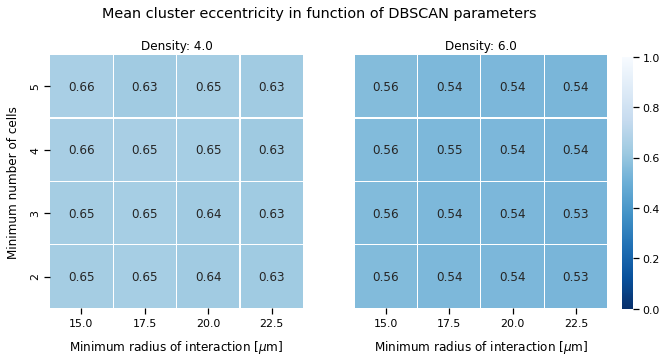

In [516]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
cbar_ax = fig.add_axes([.92, .25, .015, .5])

for index, density in enumerate(['Med', 'High']):
    med_df = eccentricity_df[eccentricity_df['density'] == density]
    med_df = med_df.drop(columns=['density', 'Collagen Concentration'])

    med_df = med_df.groupby(['n_cells', 'radius'], sort=False).agg(['mean'])
    med_df.columns = med_df.columns.droplevel(0)
    med_df.reset_index(inplace=True)
    med_df.head()
    result = pd.pivot_table(med_df, values='mean', 
                         index=['n_cells'], 
                         columns='radius')
    
    sns.heatmap(result, vmin=0, vmax=1,
                annot=True,
                linewidths=0.2, square=True,
                cmap='Blues_r',
                ax=axes[index],
                cbar=index == 0, 
                cbar_ax=None if index else cbar_ax)
    
    axes[index].set_title('Density: {}'.format(concentrations[index]))
    axes[index].set_xlabel('Minimum radius of interaction [$\mu$m]', labelpad=10)
    axes[index].invert_yaxis()
    
    
axes[0].set_ylabel('Minimum number of cells', labelpad=10)
axes[1].set_ylabel('')
axes[1].set_yticks([])
plt.suptitle('Mean cluster eccentricity in function of DBSCAN parameters', y=0.85)

In [494]:
def build_path_name(timestep, folder_name, data_type):
    """Returns a Path object with the adequate PhysiCell output name format.
    
    Uses the standard PhysiCell output filename structure,
    (output{data_type}_{time_id}.mat)
    
    Parameters
    ----------
    timestep : int
        The time point at which the output was recorded
    folder_path: Path
        The path to the folder where the output (.mat, .xml) files are stored
    data_type: string
        The type of data to be retrieved (cells for cell-based data and
        microenvironment for the continuum variables)
    """

    # All possible file types written by PhysiCell
    data_type_name = {
        'cells': 'cells_physicell'
    }

    # Variable definition
    file_name = data_type_name[data_type]
    time_str = str(timestep).zfill(8)
    file_name = 'output{}_{}.mat'.format(time_str, file_name)

    # Build path name
    path_name = folder_name / file_name

    return path_name


def get_cell_data(timestep, folder_name, variables='all'):
    """Returns a dictionary with the cell output data for the given variables.
    
    Parameters
    ----------
    timestep : int
        The time point at which the output was recorded
    folder_path: Path
        The path to the folder where the output (.mat, .xml) files are stored
    variables : list
        The variables to be extracted from the output files. If variables
        are not defined, all the available outputs will be saved.
    """

    # All possible output variables written by PhysiCell
    data_labels = [
        'ID',
        'position_x', 'position_y', 'position_z',
        'total_volume',
        'cell_type',
        'cycle_model', 'current_phase', 'elapsed_time_in_phase',
        'nuclear_volume', 'cytoplasmic_volume',
        'fluid_fraction', 'calcified_fraction',
        'orientation_x', 'orientation_y', 'orientation_z',
        'polarity',
        'migration_speed',
        'motility_vector_x', 'motility_vector_y', 'motility_vector_z',
        'migration_bias',
        'motility_bias_direction_x', 'motility_bias_direction_y', 'motility_bias_direction_z',
        'persistence_time',
        'motility_reserved'
    ]

    # Variable definition
    cells = {}
    file_type = 'cells'

    if variables == 'all':
        variables = data_labels

    # Build path name
    path_name = build_path_name(timestep, folder_name, file_type)

    # Read output file
    cell_data = sio.loadmat(path_name)['cells']

    # Select and save the variables of interest
    variables_indexes = [data_labels.index(var) for var in variables]

    for index, var, in zip(variables_indexes, variables):
        cells[var] = cell_data[index, :]

    return cells


# DATA PROCESSING
def cells_in_z_area_of_interest(cells, height_of_interest):
    """Selects cells in a defined area and returns them in a DataFrame.
    
    
    Parameters
    ---------
    cells : DataFrame
        The ax object to be stylized
    height_of_interest : int
        The threshold that defines which cells to select. Assumed to be
        equal for positive and negative z coordinates
    """
    
    # Define conditions 
    cells_above_neg_height_of_interest = cells['position_z'] > -height_of_interest
    cells_below_height_of_interest = cells['position_z'] < height_of_interest
    area_of_interest = cells_above_neg_height_of_interest & cells_below_height_of_interest
    
    # Select cells
    cells_of_interest = cells[area_of_interest]

    return cells_of_interest


def classify_cells_into_clusters(cells, DBSCAN_radius=18, DBSCAN_min_cells=3):
    """Classifies cells into clusters using the DBSCAN algorithm.
    
    Uses the cells' spatial information (x and y coordinates) through sklearn's
    DBSCAN algorithm. More information can be found at:
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
    Returns the input DataFrame, with an additional column ('cluster') corrsponding to
    the ID of the cluster the cell belongs to. Outlier cells are given an ID of -1.
    
    Parameters
    ----------
    cells : DataFrame
        The DataFrame with cell data to be classified
    DBSCAN_radius : int
        The radius to be considered by the DBSCAN algorithm
        (default is 18 [microns])
    DBSCAN_min_cells : int
        The minimum number of cells to be used by the DBSCAN algorithm
        (default is 3 cells)
    """
    
    # Classify cells based on spatial information
    cells_positions = cells[['position_x', 'position_y']]
    dbscan_clusters = DBSCAN(eps=DBSCAN_radius, min_samples=DBSCAN_min_cells).fit(cells_positions)
    
    # Update the cells DataFrame with the corresponding cluster labels
    cells['cluster'] = dbscan_clusters.labels_

    return cells


def add_cluster_centroids_to_dataframe(cells, clusters_data):
    """Computes and stores the clusters' centroids.
    
    Takes the average of the x and y coordinates of cells that belong to each
    cluster to compute the cluster's centroid.
    
    Parameters
    ----------
    cells : DataFrame
        The DataFrame with cell data to be updated
    """
    
    # Create columns to store centroids' coordinates
    cells['centroid_x'] = np.nan
    cells['centroid_y'] = np.nan
    
    # Get list to loop through clusters
    clusters = clusters_data.index

    for cluster in clusters:
        
        # Get indexes of interest
        indexes_of_cells_in_cluster = cells[cells['cluster'] == cluster].index.values

        # Remove single cells
        if cluster == -1:
            cells = cells.drop(indexes_of_cells_in_cluster)
        else:
            # Store averaged positions as centroid coordinates
            cluster_centroid = clusters_data.loc[cluster]
            cells.at[indexes_of_cells_in_cluster, 'centroid_x'] = cluster_centroid['position_x']
            cells.at[indexes_of_cells_in_cluster, 'centroid_y'] = cluster_centroid['position_y']

    return cells


def add_distances_to_dataframe(cells):
    """Computes and stores the distance between cells and the cluster centroid.
    
    For each cell, computes the Euclidian distance between the cell's coordinates
    and the centroid of the cluster the cell belongs to.
    
    Parameters
    ----------
    cells : DataFrame
        The DataFrame with cell data to be updated
    """
    
    # Create columns to store cell distances
    cells['distance_to_centroid'] = np.nan

    for cell in cells.index:
        # Get cell position
        cell_x_position = cells['position_x'].loc[cell]
        cell_y_position = cells['position_y'].loc[cell]
        cell_position = (cell_x_position, cell_y_position)
        
        # Get centroid's position
        centroid_x_position = cells['centroid_x'].loc[cell]
        centroid_y_position = cells['centroid_y'].loc[cell]
        centroid_position = (centroid_x_position, centroid_y_position)
        
        # Compute Euclidian distance
        distance = dist.euclidean(cell_position, centroid_position)
        
        # Store distance
        cells.at[cell, 'distance_to_centroid'] = distance

    return cells


def add_cluster_data(cells):
    """Computes and stores the clusters' spatial data.
    
    Uses add_cluster_centroids_to_dataframe() to compute and store the centroid
    of the cluster. Then uses add_distances_to_dataframe to update the DataFrame
    with the distances between cells and cluster centroids.
    
    Parameters
    ----------
    cells : DataFrame
        The DataFrame with cell data to be updated
    """
    
    # Get centroid
    clusters_data = cells.groupby('cluster').mean()
    cells = add_cluster_centroids_to_dataframe(cells, clusters_data)
    # Get distances
    cells = add_distances_to_dataframe(cells)

    return cells


def compute_cluster_metrics(cluster_data, cluster_list):
    """Computes and returns a list with cluster metrics.
    
    Computes the clusters'center coordinates, the mean distance
    of cells to the centroids the clusters'radius and area, as 
    well as the number of cells in each cluster.
    
    Parameters
    ----------
    cluster_data : DataFrame
        The DataFrame with cluster data to be analyzed
    cluster_list : list
        The list where the outputs will be stored
    """
    
    # Get averaged cluster data
    averaged_cluster_data = clusters_data.mean()
    # Get number of cells in each cluster
    cells_per_cluster = clusters_data['ID'].count()
    
    # Get list to loop through clusters
    clusters = averaged_cluster_data.index

    for cluster in clusters:
        # Get mean distance to centroid
        mean_distance_to_centroid = averaged_cluster_data.loc[cluster]['distance_to_centroid']
        
        # Get cluster centroid
        cluster_pos_x = averaged_cluster_data.loc[cluster]['position_x']
        cluster_pos_y = averaged_cluster_data.loc[cluster]['position_y']
        cluster_pos = (cluster_pos_x, cluster_pos_y)
        
        # Compute cluster area, assuming a circular geometry
        cluster_radius = mean_distance_to_centroid + cell_radius
        cluster_area = cluster_radius**2 * np.pi
        
        # Get number of cells in the cluster
        cells_in_cluster = cells_per_cluster.loc[cluster]
        
        # Store data
        cluster_metrics = [z_height, radius, min_cells, density, replicate, timestep,
                           cluster, cluster_pos[0], cluster_pos[1], 
                           mean_distance_to_centroid, cluster_radius, cluster_area, 
                           cells_in_cluster]
        
        cluster_list.append(cluster_metrics)
                
    return cluster_list


def compute_equivalent_ellipse(coords):
    """Computes and returns the equivalent ellipse of a set of coordinates.
    
    Uses the second moment method. Based on
    https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
    
    Parameters
    ----------
    coords : NumPy array
        The coordinates of the cells inside a cluster.
    """
    
    # Compute covariance matrix
    covariance_matrix = np.cov(coords, rowvar=False)
    vals, vecs = np.linalg.eigh(covariance_matrix)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:,order]
    
    # Get ellipse angle
    rotation_degree = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    # Get ellipse dimensions
    ellipse_x, ellipse_y = np.sqrt(vals)
    
    # Get center of ellipse
    ellipse_center = coords.mean(axis=0)
    
    return ellipse_center, ellipse_x, ellipse_y, rotation_degree


def compute_eccentricity(ellipse_x, ellipse_y):
    """ Computes and returns cluster eccentricity of an ellipse.
    
    Uses the width and height of an ellipse to compute eccentricity
    (sqrt(width^2-height^2)/width)
    
    Parameters
    ----------
    ellipse_x : float
        One of the sides of the ellipse
    ellipse_y : float
        One of the sides of the ellipse
    """
    
    # Identify width and heigth of the ellipse
    width = ellipse_x
    height = ellipse_y
    
    # Compute eccentricity
    eccentricity = np.sqrt(width ** 2 - height ** 2) / width
    
    return eccentricity


def draw_cells_as_circles(ax, cells, y_variable='position_y', clusterized=False, cell_radius=8):
    """Draws cells as circles of a defined radius.
    
    Parameters
    ----------
    ax : ax
        The ax object to draw in.
    cells : DataFrame
        The DataFrame with the cells to be drawn.
    y_variable : string
        The coordinate to be represented in the y axis (y or z, default
        is the y coordinate)
    clusterized : Boolean
        Defines if cells should be colorized based on the cluster they
        belong to (default is False, all cells get the same color)
    cell_radius : int
        The radius of the cells (default is 8 [microns])
    """
    
    # When cells are classified into clusters, cells from the same cluster are plotted with the same color.
    # Independent cells are plotted as black.
    if clusterized:
        num_colors = len(cells['cluster'].unique())

        my_palette = sns.color_palette('Spectral', num_colors)
        my_palette.insert(len(my_palette), (0,0,0))

        for x_pos, y_pos, color in zip(cells['position_x'], cells[y_variable], cells['cluster']):
            cell_contour = plt.Circle((x_pos, y_pos),
                                      cell_radius,
                                      facecolor=my_palette[color], edgecolor='black')

            ax.add_patch(cell_contour)

    # When cells are not classified into clusters, all cells are plotted with the same color.
    else:
        for x_pos, y_pos in zip(cells['position_x'], cells[y_variable]):
            cell_contour = plt.Circle((x_pos, y_pos),
                                      cell_radius,
                                      facecolor='C0', edgecolor='black')

            ax.add_patch(cell_contour)
            

def set_cell_view_style_axes(ax):
    """Sets axes style to predefined settings.
    
    Includes a light gray dashed grid and all spines set as black, 
    with ticks pointing inwards.
    
    Parameters
    ---------
    ax : ax
        The ax object to be stylized.
    """

    # Grid
    ax.yaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)
    ax.xaxis.grid(color='lightgray', linestyle='--', linewidth=0.5, zorder=-1)

    # Ticks
    ax.tick_params(axis="y", direction="in", right=True)
    ax.tick_params(axis="x", direction="in", top=True)

    # Spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')